### Imports, Data Loading, Helpers

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
telemetry = pd.read_csv('./telemetry_cleaned.csv')

In [31]:
def plot2d(data):
	data.plot(kind='scatter', x='Easting', y='Northing')

def plot3d(data, title):
	fig = plt.figure()
	ax = fig.add_subplot(projection='3d')
	ax.scatter(data['Easting'], data['Northing'], data['WaterDepth'])
	ax.set_xlabel('Easting')
	ax.set_ylabel('Northing')
	ax.set_label
	ax.set_zlabel('WaterDepth')
	ax.set_title(title)
	plt.show()


### Data Selection
First leg of the journey (10,000 points)

In [41]:
# X = telemetry[['Easting', 'Northing', 'WaterDepth']].head(10619) # 10,000
X = telemetry[['Easting', 'Northing', 'WaterDepth']].head(10619) # 1,000
X = X[X['WaterDepth'] <= 60]
X = X[X['WaterDepth'] >= 30]

### Pre-Clustering

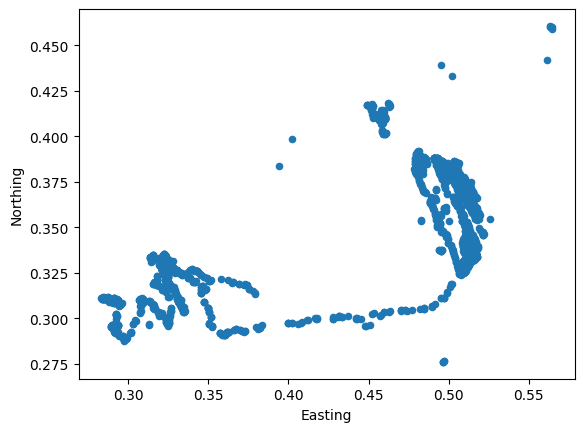

In [42]:
plot2d(X)

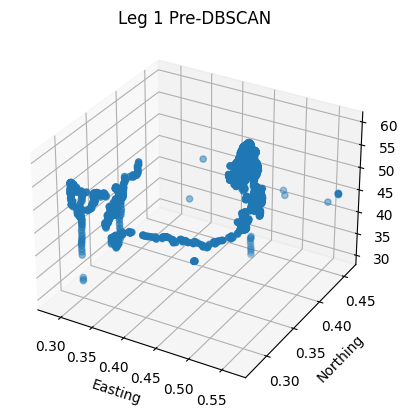

In [43]:
plot3d(X, 'Leg 1 Pre-DBSCAN')

### DBSCAN Output

In [44]:
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')

Estimated number of clusters: 4
Estimated number of noise points: 55


### Basic Evaluation
#### Silhouette Coefficient
One metric for evaluating clustering algorithms is the Silhouette Coefficient. It uses the following formula:
$$s = \frac{b-a}{\max{(a,b)}}$$

Where
- a is the mean distance between a sample and all other points within the *same* cluster
- b is the mean distance between a sample and all other points in the *next nearest* cluster

The score is calculated between a range of -1 for incorrect clustering and 1 for highly dense clustering, where a score around 0 indicates overlapping clusters. A higher score indicates dense and well separated clusters.

Adapted from [Quick Guide to Evaluation Metrics for Supervised and Unsupervised Machine Learning](https://www.analyticsvidhya.com/blog/2020/10/quick-guide-to-evaluation-metrics-for-supervised-and-unsupervised-machine-learning/) § Clustering Performance Evaluation Metrics

We can use the provided method from the metrics module to calculate the silhouette coefficient:

In [52]:
print(f'Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}')

Silhouette Coefficient: 0.595


#### Dunn's Index
Another metric is Dunn's Index. The bigger the value of the resulting Dunn index, the better the clustering result is considered, since higher values indicate that clusters are compact (small :math:`diam(c_k)`) and far apart.
$$
D = \min_{i=1 \ldots n_c; j = i + 1\ldots n_c} \left\lbrace \frac{d(c_i,c_j)}{\max_{k = 1 \ldots n_c} (\text{diam}(c_k))}\right\rbrace
$$

Where
- $d(c_i,c_j)$ represents the distance between clusters. $c_i$ and $c_j$ are given by the distances between a sample's two closest points.
- $\text{diam}(c_k)$ is the diameter of the cluster, $c_k$ is given by the sample's two furthest points

[dunn-sklearn.py](https://gist.github.com/keizerzilla/a72056c0905e57a036e57b03b557c896#file-dunn-sklearn-py-L22)

In [51]:
# def dunn(labels, distances):
# 	labels = normalize_to_smallest_integers(labels)

# 	unique_cluster_distances = np.unique(min_cluster_distances(labels, distances))
# 	max_diameter = max(diameter(labels, distances))

# 	if np.size(unique_cluster_distances) > 1:
# 		return unique_cluster_distances[1] / max_diameter
# 	else:
# 		return unique_cluster_distances[0] / max_diametery

### Plots

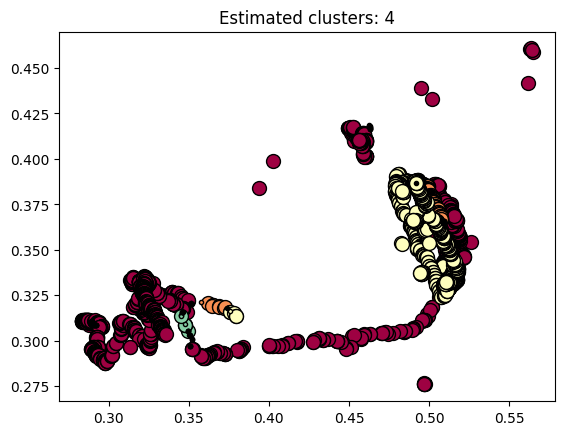

In [49]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, color in zip(unique_labels, colors):
	if k == -1:
		# Black used for noise.
		color = [0, 0, 0, 1]

	class_member_mask = labels == k

	core_samples = X[class_member_mask & core_samples_mask]

	plt.plot(
		core_samples['Easting'],
		core_samples['Northing'],
		"o",
		markerfacecolor=tuple(color),
		markeredgecolor='k',
		markersize=10,
	)

	non_core_samples = X[class_member_mask & ~core_samples_mask]
	plt.plot(
		non_core_samples['Easting'],
		non_core_samples['Northing'],
		"o",
		markerfacecolor=tuple(color),
		markeredgecolor='k',
		markersize=3,
	)

plt.title(f'Estimated clusters: {n_clusters_}')
plt.show()